In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [45]:
columns_short = np.array([
    "lp", "v", "GTT", "GTn", "GGn", "Ts", "Tp",
    "T48", "T1", "T2", "P48", "P1", "P2", "Pexh",
    "TIC", "mf", "GT_comp_decay", "GT_turb_decay"
])

Sensor_data_csv = pd.read_csv('data.txt', delimiter ='   ',header = None, names = columns_short)
Sensor_data_csv['time'] = range(len(Sensor_data_csv), 0, -1)
Sensor_data_csv.to_csv("Sensor_data.csv")

/tmp/ipykernel_36117/1174766708.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Sensor_data_csv = pd.read_csv('data.txt', delimiter ='   ',header = None, names = columns_short)


In [46]:
print(Sensor_data_csv.shape)
print(Sensor_data_csv.info())
print(Sensor_data_csv.describe())

(11934, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lp             11934 non-null  float64
 1   v              11934 non-null  float64
 2   GTT            11934 non-null  float64
 3   GTn            11934 non-null  float64
 4   GGn            11934 non-null  float64
 5   Ts             11934 non-null  float64
 6   Tp             11934 non-null  float64
 7   T48            11934 non-null  float64
 8   T1             11934 non-null  float64
 9   T2             11934 non-null  float64
 10  P48            11934 non-null  float64
 11  P1             11934 non-null  float64
 12  P2             11934 non-null  float64
 13  Pexh           11934 non-null  float64
 14  TIC            11934 non-null  float64
 15  mf             11934 non-null  float64
 16  GT_comp_decay  11934 non-null  float64
 17  GT_turb_decay  11934 non-null  float64

In [47]:

# from scipy.stats import zscore
# z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
# df = df[(z_scores < 3).all(axis=1)]

# # 5. Normalize / scale features (important since features have very different units)
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()  # z-score scaling
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# df_scaled.to_csv("cleaned_data.csv", index=False)


Derived Features

In [48]:
Efficiency_ratios = pd.DataFrame(
    {
        'Fuel to Power': Sensor_data_csv['mf'] / Sensor_data_csv['GTT'],
        'Power to Speed': Sensor_data_csv['GTT'] / Sensor_data_csv['v'],
        'Temperature-Pressure': (Sensor_data_csv['T2'] - Sensor_data_csv['T1']) / (Sensor_data_csv['P2'] - Sensor_data_csv['P1']),
    }
)
Efficiency_ratios['time'] = range(len(Efficiency_ratios), 0, -1)
Efficiency_ratios.to_csv("Efficiency_ratios.csv")

Propeller_Performance = pd.DataFrame(
    {
        'Propeller Imbalance': Sensor_data_csv['Ts'] - Sensor_data_csv['Tp'],
        'Total Propeller Torque': Sensor_data_csv['Ts'] + Sensor_data_csv['Tp'],
        'Torque Ratio': Sensor_data_csv['Ts'] / Sensor_data_csv['Tp']
    }
)
Propeller_Performance['time'] = range(len(Propeller_Performance), 0, -1)
Propeller_Performance.to_csv("Propeller_Performance.csv")


Temperature_Pressure_indicator = pd.DataFrame(
    {
        'CTR': Sensor_data_csv['T2'] / Sensor_data_csv['T1'],
        'TTR': Sensor_data_csv['T48'] / Sensor_data_csv['T2'],
        'PR': Sensor_data_csv['P2'] / Sensor_data_csv['P1'],
        'Expansion Ratio': Sensor_data_csv['P48'] / Sensor_data_csv['P2']
    }
)
Temperature_Pressure_indicator['time'] = range(len(Temperature_Pressure_indicator), 0, -1)
Temperature_Pressure_indicator.to_csv("Temperature_Pressure_indicator.csv")


Engine_Stats = pd.DataFrame(
    {
        'Shaft Torque': Sensor_data_csv['GTT'] / Sensor_data_csv['GTn'],
        'GT speed Ratio': Sensor_data_csv['GGn'] / Sensor_data_csv['GTn'],
        'Fuel per Revolution': Sensor_data_csv['mf'] / Sensor_data_csv['GTn']
    }
)
Engine_Stats['time'] = range(len(Engine_Stats), 0, -1)
Engine_Stats.to_csv("Engine_Stats.csv")


Ship_features = pd.DataFrame(
    {
        'Power per Knot': Sensor_data_csv['GTT'] * Sensor_data_csv['GTn'] / Sensor_data_csv['v'],
        'SFC': Sensor_data_csv['mf'] / Sensor_data_csv['v']
    }
)
Ship_features['time'] = range(len(Ship_features), 0, -1)
Ship_features.to_csv("Ship_features.csv")



Analysis of fuel and efficiency

<Axes: xlabel='None', ylabel='mf_rolling'>

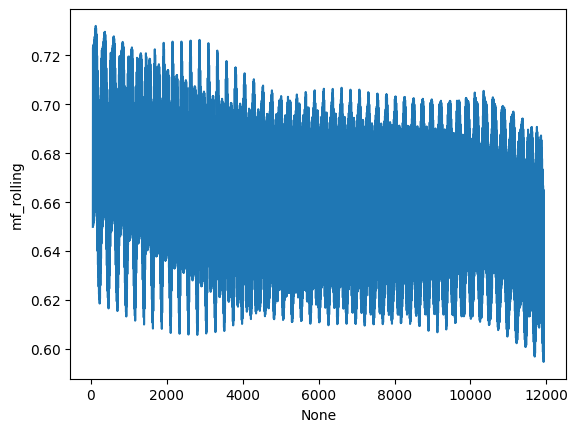

In [49]:
#sns.lineplot(data=Sensor_data_csv, x='time', y='mf')

Sensor_data_csv['mf_rolling'] = Sensor_data_csv['mf'].rolling(window=50).mean()
sns.lineplot(data=Sensor_data_csv, x=Sensor_data_csv.index, y='mf_rolling')

<Axes: xlabel='v', ylabel='mf'>

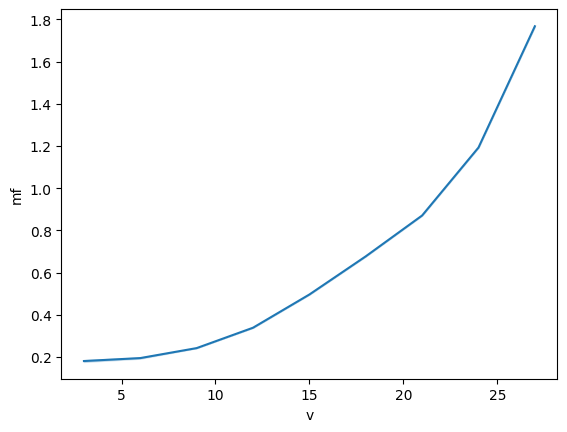

In [50]:
sns.lineplot(data =Sensor_data_csv ,x='v', y='mf')

<Axes: xlabel='v', ylabel='fuel_per_knot'>

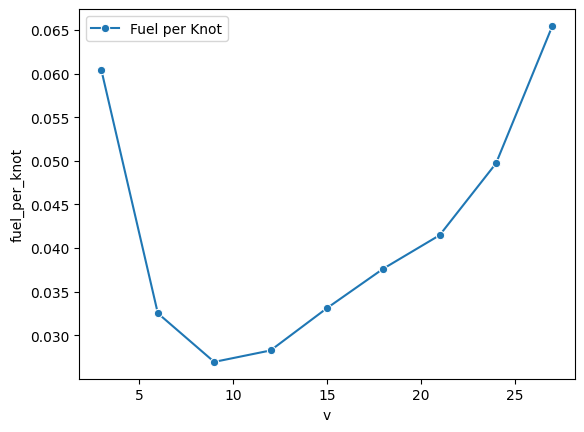

In [51]:

Sensor_data_csv['fuel_per_torque'] = Sensor_data_csv['mf'] / Sensor_data_csv['GTT']      # Fuel flow per unit torque
Sensor_data_csv['fuel_per_knot']   = Sensor_data_csv['mf'] / Sensor_data_csv['v']
efficiency = Sensor_data_csv.groupby('v').agg({
    'fuel_per_knot': 'mean',
    'fuel_per_torque': 'mean'
}).reset_index()

sns.lineplot(x='v',y='fuel_per_knot',data = efficiency, marker='o', label='Fuel per Knot')


<Axes: xlabel='v', ylabel='fuel_per_torque'>

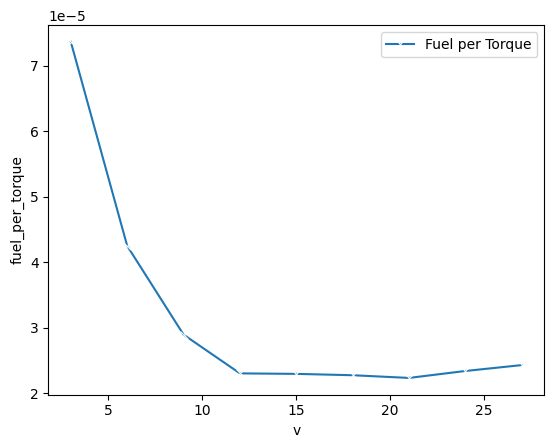

In [52]:
sns.lineplot(x='v',y='fuel_per_torque',data = efficiency, marker='x', label='Fuel per Torque')

In [ ]:
import requests

API_URL = "http://127.0.0.1:8000/add_bulk"

Sensor_data_csv = Sensor_data_csv.rename(columns={
    "GT_comp_decay": "decay_comp",
    "GT_turb_decay": "decay_turbine"
})
required_cols = [
    "lp","v","GTT","GTn","GGn","Ts","Tp","T48","T1","T2",
    "P48","P1","P2","Pexh","TIC","mf","decay_comp","decay_turbine"
]

Sensor_data_csv = Sensor_data_csv[required_cols]
API_data = Sensor_data_csv.to_dict()
import json
json_string = json.dumps(API_data, indent=4)
# requests.post(url=API_URL,json=json_string)
requests.get("http://127.0.0.1:8000")


<Response [422]>

In [56]:
Sensor_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lp               11934 non-null  float64
 1   v                11934 non-null  float64
 2   GTT              11934 non-null  float64
 3   GTn              11934 non-null  float64
 4   GGn              11934 non-null  float64
 5   Ts               11934 non-null  float64
 6   Tp               11934 non-null  float64
 7   T48              11934 non-null  float64
 8   T1               11934 non-null  float64
 9   T2               11934 non-null  float64
 10  P48              11934 non-null  float64
 11  P1               11934 non-null  float64
 12  P2               11934 non-null  float64
 13  Pexh             11934 non-null  float64
 14  TIC              11934 non-null  float64
 15  mf               11934 non-null  float64
 16  decay_comp       11934 non-null  float64
 17  decay_turbin